# Домашнее задание 1. Введение в Pytorch и DL. Базовые элементы.

In [1]:
import torch
import numpy as np
from typing import Any, List
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass

torch.manual_seed(42)

## Задание 1.

(6 баллов) Напишите функцию, которая моделирует один нейрон с сигмоидной активацией и реализует вычисление градиента для обновления весов и смещений нейрона. Функция должна принимать список векторов признаков, ассоциированные бинарные метки класса, начальные веса, начальное смещение, скорость обучения и количество эпох. Функция должна обновлять веса и смещение с помощью градиентного спуска (классической версии) на основе функции потерь NLL и возвращать обновленные веса, смещение и список значений NLL для каждой эпохи, округленное до четырех десятичных знаков.

Проведите обучение на предоставленном наборе данных из задания 4 (для двух разных лет). Опционально сгенерируйте другие подходящие наборы данных. Опишите ваши результаты. Предоставленная функция будет также протестирована во время защиты ДЗ.
Можно использовать только чистый torch (без использования autograd и torch.nn). 

Пример:

```
input: features = [[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]], 
labels = [1, 0, 0], 
initial_weights = [0.1, -0.2], 
initial_bias = 0.0, 
learning_rate = 0.1, 
epochs = 2

output: 
updated_weights = [..., ...], updated_bias = -..., mse_values = [..., ...]
```

-------------------------------------------------

Формула для NLL:

$$
\log \mathbb{P}(\mathcal{D}\mid\theta)
= \sum_{i=1}^{n} \left(
  y_i \log \hat{y}_{\theta,i}
  + (1 - y_i)\log\!\left(1 - \hat{y}_{\theta,i}\right)
\right)
$$

где $\hat{y}$:

$$\hat{y} = \sigma(Xw+b)$$

In [2]:
@dataclass
class Neuron:
    updated_weights: List[float]
    updated_bias: float
    nll_values: List[float]

In [3]:
def train(features: Any, labels: List[int], initial_weight: List[float], initial_bias: float, learning_rate: float, epochs: int) -> Neuron:
    """Функция, моделирующая один нейрон с сигмоидной активацией и реализующая вычисление градиента для обновления весов и смещений нейрона"""

    X = torch.as_tensor(features, dtype=torch.float32)
    y = torch.as_tensor(labels, dtype=torch.float32)
    w = torch.as_tensor(initial_weight, dtype=torch.float32)
    b = torch.as_tensor(initial_bias, dtype=torch.float32)
    
    eps = 1e-7
    n = X.shape[0]
    nll_values = []

    for _ in range(epochs):

        # forward
        z = torch.matmul(X, w) + b
        hat_y = torch.sigmoid(z).clamp(min=eps, max=1.0 - eps)

        # NLL
        loss = -(y * torch.log(hat_y) + (1 - y) * torch.log(1 - hat_y)).mean()

        # backward
        dz = hat_y - y
        grad_w = torch.matmul(X.T, dz) / n
        grad_b = dz.mean()

        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b

        nll_values.append(np.round(loss, 4))

    return Neuron(
        updated_weights=[float(x) for x in w],
        updated_bias=float(b.item()),
        nll_values=nll_values
    )

P.S.

$$
L_i = -y_i \log \hat y_i - (1 - y_i)\log (1 - \hat y_i).
$$

Частные производные:
$$
\frac{\partial L_i}{\partial \hat y_i}
= -\frac{y_i}{\hat y_i} + \frac{1 - y_i}{1 - \hat y_i}, 
\qquad
\frac{d \hat y_i}{d z_i} = \hat y_i (1 - \hat y_i).
$$

Тогда:
$$
dz = \frac{\partial L_i}{\partial z_i}
= \left(-\frac{y_i}{\hat y_i} + \frac{1 - y_i}{1 - \hat y_i}\right)\hat y_i(1 - \hat y_i)
= \hat y_i - y_i.
$$


$$
\nabla_w L = X^\top (\hat y - y), 
\qquad
\frac{\partial L}{\partial b} = \sum_{i=1}^{N} (\hat y_i - y_i) = \sum_{i=1}^{N}dz
$$


In [4]:
features = [[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]]
labels = [1, 0, 0]
initial_weights = [0.1, -0.2]
initial_bias = 0.0
learning_rate = 0.3
epochs = 10

In [5]:
model = train(
    features=features,
    labels=labels,
    initial_weight=initial_weights,
    initial_bias=initial_bias,
    learning_rate=learning_rate,
    epochs=epochs
)

model

Neuron(updated_weights=[-0.22863134741783142, 0.7094503045082092], updated_bias=-0.4345037639141083, nll_values=[tensor(0.8006), tensor(0.6967), tensor(0.6295), tensor(0.5806), tensor(0.5414), tensor(0.5083), tensor(0.4793), tensor(0.4535), tensor(0.4303), tensor(0.4094)])

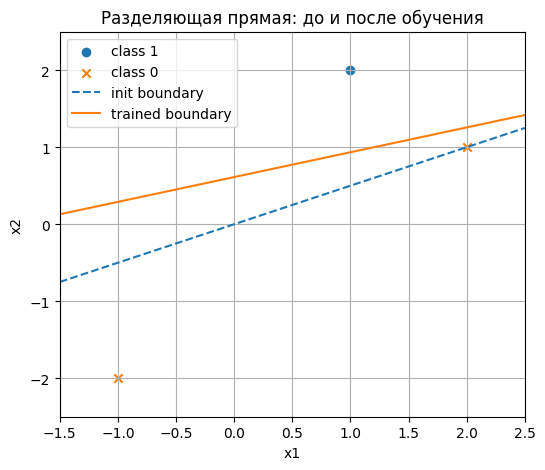

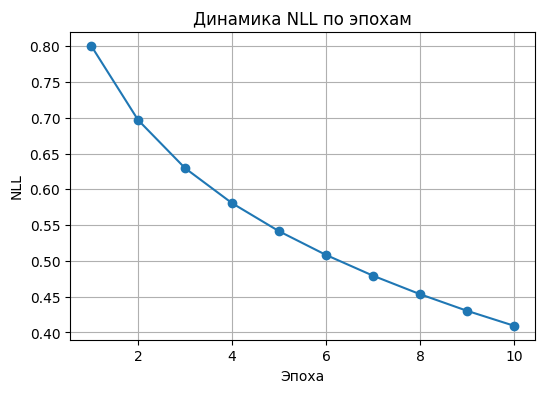

In [6]:
# Визуализация
X_np = np.asarray(features, dtype=np.float32)
y_np = np.asarray(labels, dtype=np.float32)

w0 = np.asarray(initial_weights, dtype=np.float32)
b0 = float(initial_bias)

wT = np.asarray(model.updated_weights, dtype=np.float32)
bT = float(model.updated_bias)

# ----- Вспом. функция: нарисовать прямую решения w1*x + w2*y + b = 0 -----
def plot_decision_line(ax, w, b, xlim, ylim, label=None, linestyle='-'):
    w1, w2 = float(w[0]), float(w[1])
    # Если w2 ~ 0, рисуем вертикальную прямую x = -b/w1
    if abs(w2) < 1e-12:
        x = -b / w1
        ax.plot([x, x], [ylim[0], ylim[1]], linestyle=linestyle, label=label)
    else:
        xs = np.linspace(xlim[0], xlim[1], 200)
        ys = -(w1 * xs + b) / w2
        ax.plot(xs, ys, linestyle=linestyle, label=label)


# ----- Границы осей по данным -----
pad = 0.5
xmin, xmax = X_np[:, 0].min() - pad, X_np[:, 0].max() + pad
ymin, ymax = X_np[:, 1].min() - pad, X_np[:, 1].max() + pad

# ----- (1) Точки + границы до/после -----
fig, ax = plt.subplots(figsize=(6, 5))

# Точки классов
mask1 = (y_np == 1)
mask0 = (y_np == 0)
ax.scatter(X_np[mask1, 0], X_np[mask1, 1], marker='o', label='class 1')
ax.scatter(X_np[mask0, 0], X_np[mask0, 1], marker='x', label='class 0')

# Линии решений
plot_decision_line(ax, w0, b0, (xmin, xmax), (ymin, ymax),
                   label='init boundary', linestyle='--')
plot_decision_line(ax, wT, bT, (xmin, xmax), (ymin, ymax),
                   label='trained boundary', linestyle='-')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Разделяющая прямая: до и после обучения')
ax.legend()
ax.grid(True)
plt.show()

# ----- (2) Кривая NLL по эпохам -----
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.plot(range(1, epochs+1), model.nll_values, marker='o')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('NLL')
ax2.set_title('Динамика NLL по эпохам')
ax2.grid(True)
plt.show()

### 1.1. Проверка на датасете из задания 4.

In [7]:
train_x = pd.read_csv('../data/songs/train_x.csv', index_col=0)
train_y = pd.read_csv('../data/songs/train_y.csv', index_col=0)

y_year_all = train_y["year"].astype(int).to_numpy()

train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,-0.46428,...,104.03557,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682
111484,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,-5.58019,...,11.58664,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676
448402,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,10.75028,...,23.61190,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276
254414,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,-4.29075,...,25.11398,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130
272580,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,31.69655,...,-9.89388,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840


In [8]:
# два самых частых года
YEAR_A, YEAR_B = pd.Series(y_year_all).value_counts().index[:2].tolist()
print(YEAR_A, YEAR_B)

mask = np.isin(y_year_all, [YEAR_A, YEAR_B])
X_df = train_x.loc[mask].reset_index(drop=True)
y_year = y_year_all[mask]
y_bin = (y_year == YEAR_A).astype(np.float32)

2007 2006


In [9]:
# стандартизация
scaler = StandardScaler(with_mean=True, with_std=True)
X_std = scaler.fit_transform(X_df.values)

In [20]:
# инициализирую веса равномерно в [-1/√D, 1/√D] (Xavier)

D = X_std.shape[1]
limit = 1.0 / np.sqrt(D)
initial_weights = torch.empty(
    D, dtype=torch.float32).uniform_(-limit, limit).tolist()
initial_bias = limit
learning_rate = 0.1
epochs = 100

In [21]:
model = train(
    features=X_std,
    labels=y_bin.tolist(),
    initial_weight=initial_weights,
    initial_bias=initial_bias,
    learning_rate=learning_rate,
    epochs=epochs
)

Пара лет: 2007 (класс=1) vs 2006 (класс=0)
Первые 5 NLL: [tensor(0.7666), tensor(0.7517), tensor(0.7409), tensor(0.7329), tensor(0.7269)]
Последние 5 NLL: [tensor(0.6791), tensor(0.6791), tensor(0.6790), tensor(0.6790), tensor(0.6789)]
Bias: 0.07231993228197098
Accuracy (train subset): 0.5237


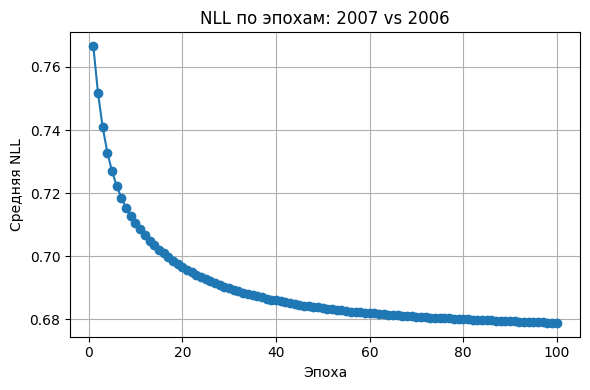

In [22]:
print(f"Пара лет: {YEAR_A} (класс=1) vs {YEAR_B} (класс=0)")
print("Первые 5 NLL:", model.nll_values[:5])
print("Последние 5 NLL:", model.nll_values[-5:])
print("Bias:", model.updated_bias)

# --- Точность на обучающем подмножестве ---
wT = np.array(model.updated_weights, dtype=np.float32)
bT = float(model.updated_bias)
proba = 1.0 / (1.0 + np.exp(-(X_df @ wT + bT)))
pred = (proba >= 0.5).astype(np.float32)
acc = (pred == y_bin).mean()
print(f"Accuracy (train subset): {acc:.4f}")

# --- График NLL по эпохам ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), model.nll_values, marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Средняя NLL')
plt.title(f'NLL по эпохам: {YEAR_A} vs {YEAR_B}')
plt.grid(True)
plt.tight_layout()
plt.show()

При большом количестве эпох (>60) NLL выходит на плато

In [ ]:
print(f"Пара лет: {YEAR_A} (класс=1) vs {YEAR_B} (класс=0)")
print("Первые 5 NLL:", model.nll_values[:5])
print("Последние 5 NLL:", model.nll_values[-5:])
print("Bias:", model.updated_bias)

# --- Точность на обучающем подмножестве ---
wT = np.array(model.updated_weights, dtype=np.float32)
bT = float(model.updated_bias)
proba = 1.0 / (1.0 + np.exp(-(X_df @ wT + bT)))
pred = (proba >= 0.5).astype(np.float32)
acc = (pred == y_bin).mean()
print(f"Accuracy (train subset): {acc:.4f}")

# --- График NLL по эпохам ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), model.nll_values, marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Средняя NLL')
plt.title(f'NLL по эпохам: {YEAR_A} vs {YEAR_B}')
plt.grid(True)
plt.tight_layout()
plt.show()

NLL продолжает снижатьс

## Задание 2.
(10 баллов) Реализуйте базовые функции autograd. Можете вдохновиться видео от Andrej Karpathy. Напишите класс, аналогичный предоставленному классу 'Element', который реализует основные операции autograd: сложение, умножение и активацию ReLU. Класс должен обрабатывать скалярные объекты и правильно вычислять градиенты для этих операций посредством автоматического дифференцирования. Плюсом будет набор предоставленных тестов, оценивающих правильность вычислений. Большим плюсом будет, если тесты будут написаны с помощью unittest. Можно использовать только чистый torch (без использования autograd и torch.nn). За каждую нереализованную операцию будет вычитаться 3 балла.

Пример: 
```
a = Node(2)
b = Node(-3)
c = Node(10)
d = a + b * c
e = d.relu()
e.backward()
print(a, b, c, d, e)

Output:  
Node(data=2, grad=0)  Node(data=-3, grad=10)  Node(data=10, grad=-3)  Node(data=-28, grad=1)  Node(data=0, grad=1)
```

In [13]:
class Node:
	def __init__(self, data, _children=(), _op=''):
		self.data = data
		self.grad = 0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op

	def __repr__(self):
		return f" Element(data={self.data}, grad={self.grad})"

	def __add__(self, other):
		if not isinstance(other, Node):
			other = Node(other)

		out = Node(self.data + other.data, (self, other), '+')

		def _backward():
			self.grad += out.grad
			other.grad += out.grad

		out._backward = _backward
		return out

	def __mul__(self, other):
		if not isinstance(other, Node):
			other = Node(other)

		out = Node(self.data * other.data, (self, other), '*')

		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		
		out._backward = _backward
		return out

	def relu(self):

		out = Node(self.data if self.data > 0 else 0, (self,), 'ReLU')

		def _backward():
			self.grad += (1 if self.data > 0 else 1) * out.grad

		out._backward = _backward
		return out

	def backward(self):
		topo = []
		visited = set()

		# граф
		def build(v):
			if v not in visited:
				visited.add(v)
				for p in v._prev:
					build(p)
				topo.append(v)

		build(self)

		# обнуляем градиенты
		for v in topo:
			v.grad = 0

		# градиент цели по себе = 1
		self.grad = 1

		for v in reversed(topo):
			v._backward()

In [14]:
a = Node(2)
b = Node(-3)
c = Node(10)
d = a + b * c
e = d.relu()
e.backward()
print(a, b, c, d, e)

 Element(data=2, grad=1)  Element(data=-3, grad=10)  Element(data=10, grad=-3)  Element(data=-28, grad=1)  Element(data=0, grad=1)


In [15]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(-3.0, requires_grad=True)
c = torch.tensor(10.0, requires_grad=True)

d = a + b * c    
e = torch.relu(d)      

d.retain_grad()
e.retain_grad()
e.backward()
print(f"Element(data={a.item()}, grad={a.grad.item()})", end='  ')
print(f"Element(data={b.item()}, grad={b.grad.item()})", end='  ')
print(f"Element(data={c.item()}, grad={c.grad.item()})", end='  ')
print(f"Element(data={d.item()}, grad={d.grad.item()})", end='  ')
print(f"Element(data={e.item()}, grad={e.grad.item()})")


Element(data=2.0, grad=0.0)  Element(data=-3.0, grad=0.0)  Element(data=10.0, grad=-0.0)  Element(data=-28.0, grad=0.0)  Element(data=0.0, grad=1.0)


In [23]:
import unittest

unittest.main(argv=[''], verbosity=2, exit=False)

class TestNodeAutograd(unittest.TestCase):
    def test_add_forward_backward(self):
        a = Node(2)
        b = Node(3)
        z = a + b          # 5
        z.backward()
        self.assertAlmostEqual(z.data, 5)
        self.assertAlmostEqual(z.grad, 1)
        self.assertAlmostEqual(a.grad, 1)
        self.assertAlmostEqual(b.grad, 1)

    def test_mul_forward_backward(self):
        a = Node(2)
        b = Node(-3)
        z = a * b          # -6
        z.backward()
        self.assertAlmostEqual(z.data, -6)
        self.assertAlmostEqual(z.grad, 1)
        # dz/da = b, dz/db = a
        self.assertAlmostEqual(a.grad, -3)
        self.assertAlmostEqual(b.grad, 2)

    # --- ReLU ---
    def test_relu_positive_passes(self):
        x = Node(5)
        y = x.relu()       # 5
        y.backward()
        self.assertAlmostEqual(y.data, 5)
        self.assertAlmostEqual(y.grad, 1)
        # dReLU/dx = 1 при x > 0
        self.assertAlmostEqual(x.grad, 1, msg="ReLU должна пропускать градиент")

    def test_backward_resets_grads(self):
        a = Node(2)
        b = Node(3)
        z = a + b
        z.backward()   # первый прогон
        self.assertAlmostEqual(a.grad, 1)

        self.assertAlmostEqual(b.grad, 1)
        self.assertAlmostEqual(z.grad, 1)

        # второй прогон по той же цели должен дать те же значения (не удвоенные)
        z.backward()
        self.assertAlmostEqual(a.grad, 1, msg="Градиенты должны обнуляться внутри backward() перед проходом")
        self.assertAlmostEqual(b.grad, 1)
        self.assertAlmostEqual(z.grad, 1)



test_add_forward_backward (__main__.TestNodeAutograd) ... ok
test_backward_resets_grads (__main__.TestNodeAutograd) ... ok
test_mul_forward_backward (__main__.TestNodeAutograd) ... ok
test_relu_positive_passes (__main__.TestNodeAutograd) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


## Задание 3. 
Реализуйте один из оптимизаторов на выбор. Придумайте и напишите тесты для проверки выбранного оптимизатора. Проведите обучение нейрона из первого задания с использованием оптимизатора, а не ванильного градиентного спуска.
Также опишите идею алгоритма (+1 балл).
{*} Можете реализовать более 1 алгоритма. Каждый следующий даст 1 балл. 

Варианты:
- Momentum (3 балла)
- Nesterov (3 балла) 
- Adagrad (4 балла)
- Adadelta (4 балла)
- RMSProp (5 баллов)
- Adam (5 баллов)
- Nadam (6 баллов)
- NAG (6 баллов)
- AdamW (6 баллов)

### 3.1. Описание идеи

Мотивация использования альтернативных от SGD оптимизаторов (из статьи https://habr.com/ru/articles/318970):

* Застревание в локальных минимумах или седловых точках, коих для функции многих переменных может быть очень много.
* Сложный ландшафт целевой функции: плато чередуются с регионами сильной нелинейности. Производная на плато практически равна нулю, а внезапный обрыв, наоборот, может отправить нас слишком далеко.
* Некоторые параметры обновляются значительно реже других, особенно когда в данных встречаются информативные, но редкие признаки, что плохо сказывается на нюансах обобщающего правила сети. С другой стороны, придание слишком большой значимости вообще всем редко встречающимся признакам может привести к переобучению.
* Слишком маленькая скорость обучения заставляет алгоритм сходиться очень долго и застревать в локальных минимумах, слишком большая — «пролетать» узкие глобальные минимумы или вовсе расходиться
 

Adam — adaptive moment estimation. Он сочетает в себе и идею накопления движения (Nesterov) и идею более слабого обновления весов (Adagrad) для типичных признаков.

Adam корректирует шаг обучения для каждого параметра, используя экспоненциально взвешенные средние первых и вторых моментов градиента.

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

где  
- $ g_t $ — текущий градиент,  
- $ m_t $ — «momentum» (первый момент, средний градиент),  
- $ v_t $ — «velocity» (второй момент, средний квадрат градиента).

---


In [17]:
def train_adam(
    features: Any,
    labels: List[int],
    initial_weight: List[float],
    initial_bias: float,
    learning_rate: float,
    epochs: int,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8
) -> Neuron:
    """
    Обучение одного нейрона с сигмоидной активацией и оптимизатором Adam."""

    X = torch.as_tensor(features, dtype=torch.float32)
    y = torch.as_tensor(labels, dtype=torch.float32)
    w = torch.as_tensor(initial_weight, dtype=torch.float32)
    b = torch.as_tensor(initial_bias, dtype=torch.float32)

    n = X.shape[0]
    nll_values = []

    m_w = torch.zeros_like(w)
    v_w = torch.zeros_like(w)
    m_b = torch.zeros_like(b)
    v_b = torch.zeros_like(b)

    for t in range(1, epochs + 1):
        # forward
        z = torch.matmul(X, w) + b
        hat_y = torch.sigmoid(z).clamp(min=eps, max=1.0 - eps)

        # NLL
        loss = -(y * torch.log(hat_y) + (1 - y) * torch.log(1 - hat_y)).mean()

        # backward
        dz = hat_y - y
        grad_w = torch.matmul(X.T, dz) / n
        grad_b = dz.mean()

        # обновление моментов
        m_w = beta1 * m_w + (1 - beta1) * grad_w
        v_w = beta2 * v_w + (1 - beta2) * (grad_w ** 2)

        m_b = beta1 * m_b + (1 - beta1) * grad_b
        v_b = beta2 * v_b + (1 - beta2) * (grad_b ** 2)

        # bias 
        m_w_hat = m_w / (1 - beta1 ** t)
        v_w_hat = v_w / (1 - beta2 ** t)

        m_b_hat = m_b / (1 - beta1 ** t)
        v_b_hat = v_b / (1 - beta2 ** t)

        # обновление параметров
        w = w - learning_rate * m_w_hat / (torch.sqrt(v_w_hat) + eps)
        b = b - learning_rate * m_b_hat / (torch.sqrt(v_b_hat) + eps)

        nll_values.append(np.round(loss.item(), 4))

    return Neuron(
        updated_weights=[float(x) for x in w],
        updated_bias=float(b.item()),
        nll_values=nll_values
    )


In [18]:
# те же параметры, что из задачи 1
features = [[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]]
labels = [1, 0, 0]
initial_weights = [0.1, -0.2]
initial_bias = 0.0
learning_rate = 0.3
epochs = 10


model = train_adam(
    features, labels, initial_weights, initial_bias,
    learning_rate=learning_rate, epochs=10
)

print(model)

Neuron(updated_weights=[-1.2528685331344604, 2.3452389240264893], updated_bias=-1.7915900945663452, nll_values=[np.float64(0.8006), np.float64(0.6443), np.float64(0.5097), np.float64(0.4032), np.float64(0.3266), np.float64(0.2716), np.float64(0.2276), np.float64(0.1886), np.float64(0.1545), np.float64(0.1265)])


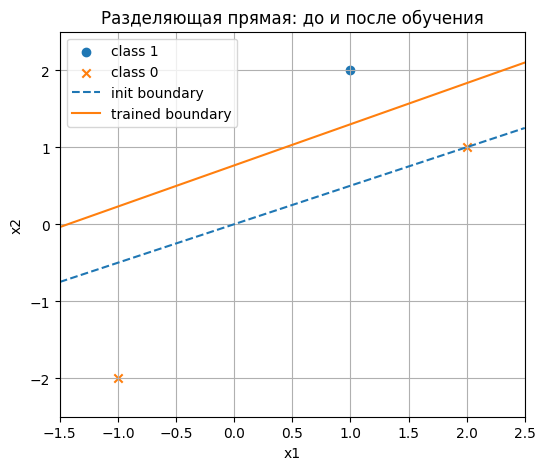

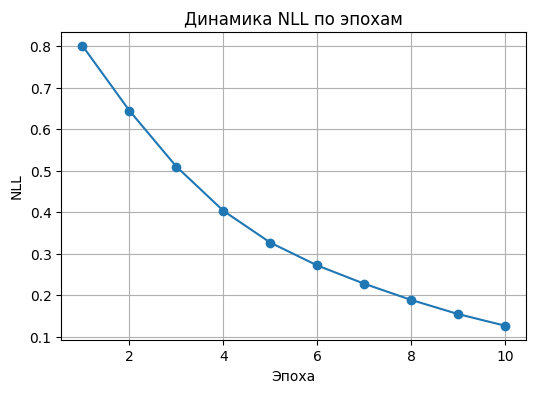

In [19]:
# Визуализация
X_np = np.asarray(features, dtype=np.float32)
y_np = np.asarray(labels, dtype=np.float32)

w0 = np.asarray(initial_weights, dtype=np.float32)
b0 = float(initial_bias)

wT = np.asarray(model.updated_weights, dtype=np.float32)
bT = float(model.updated_bias)

# ----- Вспом. функция: нарисовать прямую решения w1*x + w2*y + b = 0 -----
def plot_decision_line(ax, w, b, xlim, ylim, label=None, linestyle='-'):
    w1, w2 = float(w[0]), float(w[1])
    # Если w2 ~ 0, рисуем вертикальную прямую x = -b/w1
    if abs(w2) < 1e-12:
        x = -b / w1
        ax.plot([x, x], [ylim[0], ylim[1]], linestyle=linestyle, label=label)
    else:
        xs = np.linspace(xlim[0], xlim[1], 200)
        ys = -(w1 * xs + b) / w2
        ax.plot(xs, ys, linestyle=linestyle, label=label)


# ----- Границы осей по данным -----
pad = 0.5
xmin, xmax = X_np[:, 0].min() - pad, X_np[:, 0].max() + pad
ymin, ymax = X_np[:, 1].min() - pad, X_np[:, 1].max() + pad

# ----- (1) Точки + границы до/после -----
fig, ax = plt.subplots(figsize=(6, 5))

# Точки классов
mask1 = (y_np == 1)
mask0 = (y_np == 0)
ax.scatter(X_np[mask1, 0], X_np[mask1, 1], marker='o', label='class 1')
ax.scatter(X_np[mask0, 0], X_np[mask0, 1], marker='x', label='class 0')

# Линии решений
plot_decision_line(ax, w0, b0, (xmin, xmax), (ymin, ymax),
                   label='init boundary', linestyle='--')
plot_decision_line(ax, wT, bT, (xmin, xmax), (ymin, ymax),
                   label='trained boundary', linestyle='-')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Разделяющая прямая: до и после обучения')
ax.legend()
ax.grid(True)
plt.show()

# ----- (2) Кривая NLL по эпохам -----
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.plot(range(1, epochs+1), model.nll_values, marker='o')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('NLL')
ax2.set_title('Динамика NLL по эпохам')
ax2.grid(True)
plt.show()

Как видно из графиков, при оптимизиаторе Adam наблюдается большая сходимость (NLL 0.1265 против NLL 0.4 у GD)